In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dense

In [2]:
train_path = "../dataset/preprocessed/netflix_train.csv"
val_path = "../dataset/preprocessed/netflix_val.csv"
test_path = "../dataset/preprocessed/netflix_test.csv"

train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['description'])

X_train = tokenizer.texts_to_sequences(train_data['description'])
X_val = tokenizer.texts_to_sequences(val_data['description'])
X_test = tokenizer.texts_to_sequences(test_data['description'])

max_len = max(len(x) for x in X_train)
X_train = pad_sequences(X_train, maxlen=max_len)
X_val = pad_sequences(X_val, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

le = LabelEncoder()
y_train = le.fit_transform(train_data['target_ages'])
y_val = le.transform(val_data['target_ages'])
y_test = le.transform(test_data['target_ages'])

In [3]:
def resnet_block(x, filters, kernel_size=1, stride=1, conv_shortcut=False):
    res = x
    if conv_shortcut:
        res = Conv1D(filters, kernel_size=1, strides=stride, padding='same')(res)
        res = BatchNormalization()(res)

    x = Conv1D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, res])
    x = Activation('relu')(x)
    return x

input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len)(input_layer)

x = resnet_block(embedding_layer, filters=64, conv_shortcut=True)
x = resnet_block(x, filters=64)
#x = resnet_block(x, filters=64)

x = GlobalAveragePooling1D()(x)

output_layer = Dense(len(le.classes_), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)



Epoch 1/10


193/193 [==============================] - 7s 23ms/step - loss: 1.0873 - accuracy: 0.4968 - val_loss: 1.5066 - val_accuracy: 0.1744
Epoch 2/10
193/193 [==============================] - 4s 20ms/step - loss: 0.6971 - accuracy: 0.7228 - val_loss: 1.4649 - val_accuracy: 0.3169
Epoch 3/10
193/193 [==============================] - 4s 20ms/step - loss: 0.3582 - accuracy: 0.8819 - val_loss: 1.2158 - val_accuracy: 0.4701
Epoch 4/10
193/193 [==============================] - 4s 19ms/step - loss: 0.1640 - accuracy: 0.9576 - val_loss: 1.5622 - val_accuracy: 0.4882
Epoch 5/10
193/193 [==============================] - 4s 19ms/step - loss: 0.0788 - accuracy: 0.9839 - val_loss: 1.8175 - val_accuracy: 0.4860
Epoch 6/10
193/193 [==============================] - 4s 19ms/step - loss: 0.0410 - accuracy: 0.9956 - val_loss: 1.9999 - val_accuracy: 0.4807
Epoch 7/10
193/193 [==============================] - 4s 19ms/step - loss: 0.0233 - accuracy: 0.9981 - val_loss: 2.1591 - val_accuracy: 0.4

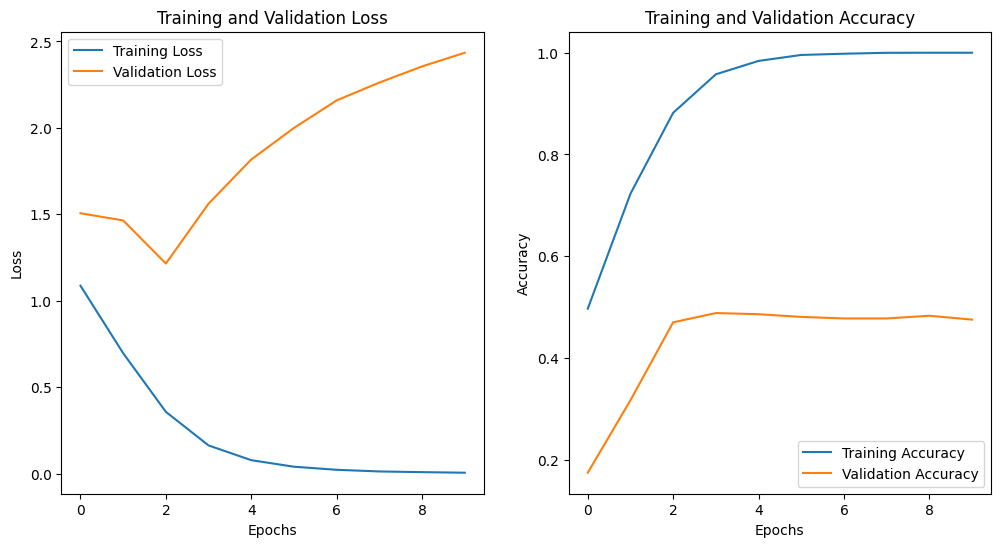

In [4]:

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()